# Realtime Classification

Let say you want to cut your realtime recording audio by using VAD after that classify using classification models, you can do that with Malaya-Speech!

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/realtime-classification](https://github.com/huseinzol05/malaya-speech/tree/master/example/realtime-classification).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [1]:
import malaya_speech
from malaya_speech import Pipeline

### Load VAD model

Fastest and common model people use, is webrtc. Read more about VAD at https://malaya-speech.readthedocs.io/en/latest/load-vad.html

In [2]:
webrtc = malaya_speech.vad.webrtc()

### Recording interface

So, to start recording audio including realtime VAD and Classification, we need to use `malaya_speech.streaming.record`. We use `pyaudio` library as the backend.

```python
def record(
    vad,
    asr_model = None,
    classification_model = None,
    device = None,
    input_rate: int = 16000,
    sample_rate: int = 16000,
    blocks_per_second: int = 50,
    padding_ms: int = 300,
    ratio: float = 0.75,
    min_length: float = 0.1,
    filename: str = None,
    spinner: bool = False,
):
    """
    Record an audio using pyaudio library. This record interface required a VAD model.

    Parameters
    ----------
    vad: object
        vad model / pipeline.
    asr_model: object
        ASR model / pipeline, will transcribe each subsamples realtime.
    classification_model: object
        classification pipeline, will classify each subsamples realtime.
    device: None
        `device` parameter for pyaudio, check available devices from `sounddevice.query_devices()`.
    input_rate: int, optional (default = 16000)
        sample rate from input device, this will auto resampling.
    sample_rate: int, optional (default = 16000)
        output sample rate.
    blocks_per_second: int, optional (default = 50)
        size of frame returned from pyaudio, frame size = sample rate / (blocks_per_second / 2).
        50 is good for WebRTC, 30 or less is good for Malaya Speech VAD.
    padding_ms: int, optional (default = 300)
        size of queue to store frames, size = padding_ms // (1000 * blocks_per_second // sample_rate)
    ratio: float, optional (default = 0.75)
        if 75% of the queue is positive, assumed it is a voice activity.
    min_length: float, optional (default=0.1)
        minimum length (s) to accept a subsample.
    filename: str, optional (default=None)
        if None, will auto generate name based on timestamp.
    spinner: bool, optional (default=False)
        if True, will use spinner object from halo library.


    Returns
    -------
    result : [filename, samples]
    """
```

**pyaudio will returned int16 bytes, so we need to change to numpy array, normalize it to -1 and +1 floating point**.

### Check available devices

In [3]:
import sounddevice

sounddevice.query_devices()

> 0 MacBook Pro Microphone, Core Audio (1 in, 0 out)
< 1 MacBook Pro Speakers, Core Audio (0 in, 2 out)
  2 JustStream Audio Driver, Core Audio (2 in, 2 out)

By default it will use `0` index.

### Load Classification models

In this example, I am going to use 3 different modules, gender detection, language detection and age detection.

In [4]:
gender_model = malaya_speech.gender.deep_model(model = 'vggvox-v2')
language_detection_model = malaya_speech.language_detection.deep_model(model = 'vggvox-v2')
age_model = malaya_speech.age_detection.deep_model(model = 'vggvox-v2')

### Classification Pipeline

Because pyaudio will returned int16 bytes, so we need to change to numpy array then normalize to float, feel free to add speech enhancement or any function, but in this example, I just keep it simple. **And needs to end with `classification` map or else `malaya_speech.streaming.record` will throw an error**.

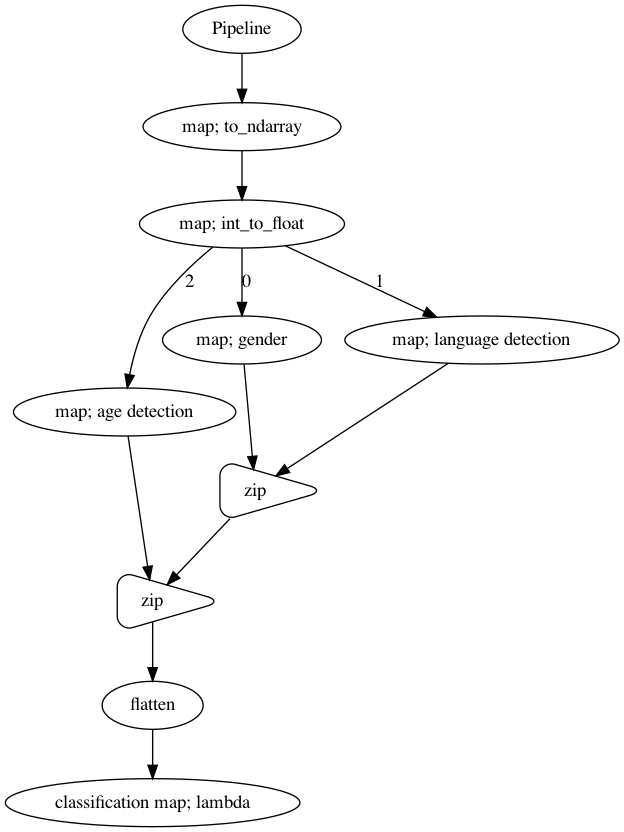

In [5]:
p_classification = Pipeline()
to_float = p_classification.map(malaya_speech.astype.to_ndarray).map(malaya_speech.astype.int_to_float)
gender = to_float.map(gender_model)
language_detection = to_float.map(language_detection_model)
age_detection = to_float.map(age_model)
combined = gender.zip(language_detection).zip(age_detection).flatten()
combined.map(lambda x: x, name = 'classification')

p_classification.visualize()

**Again, once you start to run the code below, it will straight away recording your voice**. 

If you run in jupyter notebook, press button stop up there to stop recording, if in terminal, press `CTRL + c`.

In [6]:
file, samples = malaya_speech.streaming.record(webrtc, classification_model = p_classification)

Listening (ctrl-C to stop recording) ... 

Sample 0 2021-05-31 23:39:19.638932: ['male', 'not a language', 'not an age']
Sample 1 2021-05-31 23:39:19.874754: ['male', 'malay', 'teens']
Sample 2 2021-05-31 23:39:21.262149: ['not a gender', 'not a language', 'not an age']
Sample 3 2021-05-31 23:39:23.363767: ['not a gender', 'not a language', 'not an age']
Sample 4 2021-05-31 23:39:28.221167: ['male', 'not a language', 'teens']
Sample 5 2021-05-31 23:39:31.076877: ['male', 'malay', 'teens']
Sample 6 2021-05-31 23:39:35.456165: ['male', 'not a language', 'teens']
Sample 7 2021-05-31 23:39:38.438468: ['male', 'not a language', 'teens']
Sample 8 2021-05-31 23:39:40.711461: ['male', 'not a language', 'teens']
saved audio to savewav_2021-05-31_23-39-42_725496.wav


In [7]:
import IPython.display as ipd

ipd.Audio(file)

In [8]:
len(samples)

9

In [9]:
type(samples[0][0]), samples[0][1]

(bytearray, ['male', 'not a language', 'not an age'])